# TW Hya Imaging Tutorial

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
<b>PRIISM</b> is an imaging tool for radio interferometry based on the sparse modeling technique (<a href="https://github.com/tnakazato/priism" target="_blank" rel="noopener">PRIISM</a>: Python Module for Radio Interferometry Imaging with Sparse Modeling). 
In the tutorial, we try synthesis imaging for ALMA interferometry data using PRIISM. 

## ALMA Data : TW Hya

Sample data for the tutorial is the protoplanetary disk "**TW Hydra**" observed at Band 7 with ALMA 12m array (Project 2011.0.00340.S). 
The data infromation is taken in [First Look at Imaging CASA 6](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6), and the data, which is a calibrated measurement set (MS) for CASA, can be downloaded from the link below: 

https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

After you download the data, you should extract the MS from the file. You may run the following cell to obtain the dataset.

In [1]:
%%bash
# download if necessary
[ -e sis14_twhya_calibrated_flagged.ms.tar ] || wget -nv https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

# extract MS if it doesn't exist
[ -e sis14_twhya_calibrated_flagged.ms ] || tar xvf sis14_twhya_calibrated_flagged.ms.tar

## Setup and Initialize PRIISM

Before you start this tutorial, you should install PRIISM and packages that PRIISM depends on (casatools, casatasks, etc.). Please see README.md on how to install PRIISM.

In PRIISM, we have two modules `priism` and `priism.alma`. The former is a set of core functionalities and primitive interface while the later is high-level interface specific to ALMA data. Here, we will use `priism.alma` because we are working with ALMA data. As a first step, we should create worker instance with solver option. The `mfista_nufft` solver is an implementation of MFISTA algorithm based on NUFFT. 

In [2]:
import priism.alma
print(f'PRIISM version {priism.__version__}')

worker = priism.alma.AlmaSparseModelingImager(solver='mfista_nufft')

LOG: initialize sakura...
<module 'priism.external.sakura.libsakurapy' from '/Users/nakazato/pyenv/priism/lib/python3.8/site-packages/priism-0.11.5-py3.8.egg/priism/external/sakura/libsakurapy.so'>
PRIISM version 0.11.5


We make matplotlib figures to be displayed in the notebook.

In [3]:
%matplotlib inline

## Data Preparation

Next, we average visibility channels according to the procedure described in [the CASA Guide](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6#Image_the_science_target). This requires `casatasks` that should have been installed as a dependency of PRIISM. We use `twhya_smoothed.ms` in the subsequent steps.

In [21]:
import os
import shutil
from casatasks import listobs, split, rmtables

outputvis = 'twhya_smoothed.ms'
listfile = 'twhya_smoothed.listobs.txt'

# overwrite output data if it exists
rmtables(outputvis)

split(vis='sis14_twhya_calibrated_flagged.ms', field='5', width='8', outputvis=outputvis, datacolumn='data')

data_summary = listobs(outputvis, verbose=True, overwrite=True, listfile=listfile)

os.system(f'grep -E "^Spectral Windows:" -A 2 {listfile}')

Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name                           #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz) BBC Num  Corrs  
  0      ALMA_RB_07#BB_2#SW-01#FULL_RES     48   TOPO  372535.223      4882.812    234375.0 372649.9688        2  XX  YY


0

## Data Selection

Next step is to select visibility data to be processed. The `worker` has `selectdata` method for this purpose. Its interface might be familiar with CASA users. You should set MS to `vis`. Also, you should specify name of data column to use with `datacolumn`. `selectdata` accepts major data selection parameters in CASA. Here, we select data with `spw` and `intent`. 

In [5]:
worker.selectdata(vis='twhya_smoothed.ms',
                  spw='0:24',
                  intent='OBSERVE_TARGET#ON_SOURCE',
                  datacolumn='data')

## Image Configuration

Then, image to be created should be configured with `defineimage` function. Again, parameters for it might be familiar with CASA users. Note that `phasecenter` currently accepts field id only. Also, `nchan` should be 1. These limitation may be relaxed in the future. 

In [6]:
worker.defineimage(imsize=[256, 256],
                   cell=['0.08arcsec'],
                   phasecenter='0',  # TW Hya
                   nchan=1,
                   start=0,
                   width=1)

## Read Visibility Data

Configuration has been done. And actual processing starts from here. First processing step is to read MS and load visibility data onto the memory. 

This step may take up to a minute.

In [7]:
%%timeit -n 1 -r 1

worker.readvis()

***WARN*** refocusing is disabled even if distance to the source is known.


read 200 visibility chunks

DONE reading visibility chunks
5.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


read 270 visibility chunks


## Direct Imaging

Now you can create an image from the visibility data. There are two parameters for imaging: `L1` and `Ltsv`. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. For imaging, you should run `solve` to solve the problem and then run `exportimage` to export the solution as FITS image. 

This step may take up to a minute.

In [8]:
%%timeit -n 1 -r 1
%%capture --no-display capture_solve

worker.solve(l1=1e0, ltsv=1e8, maxiter=1000, storeinitialimage=True, scalehyperparam=False)
worker.exportimage(imagename='twhya_b7cont.fits', overwrite=True)

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.09517e+08
lambda_l1:        1
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        5.47586e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.14029e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52462580.84038, c = 19277164471.47657
   21 cost = 51649461.65577, c = 7432181401.20717
   31 cost = 51453715.35663, c = 2865427665.05840
   41 cost = 51389090.54457, c = 3151970431.56424
   51 cost = 51370649.55390, c = 3151970431.56424
   61 cost = 51360754.32428, c = 3467167474.72066
   71 cost = 51355467.72160, c = 3151970431.56424
   81 cost = 51352577.74984, c = 3467167474.72066
   91 cost = 51350636.50762, c = 3467167474.72066
  101 cost = 51349338.36022, c = 31519

In [ ]:
capture_solve.show()

## Cross-Validation: Finding The Most Reliable Image 

In the previous step, `L1` and `Ltsv` are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of `L1-Ltsv` parameter space. This step is a shorthand for  cross validation. We will search only 3x3 parameter space (`L1_list` and `Ltsv_list`) and will perform 4-fold cross validation (default is 10-fold). The most reliable image will be stored in `mycvresult.fits` (i.e., `f'{imageprefix}.fits'`). 

Although this is shorthand, it may take up to tens of minutes depending on the machine spec.

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        10000
  L1 cost         61.895
lambda_tsv:       1e+06
  TSV cost        0.0015169
total cost        5.1815e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51815220.37118, c = 50000000000.00000
   11 cost = 51801212.49740, c = 19277164471.47657
   21 cost = 51756807.98834, c = 7432181401.20717
   31 cost = 51673677.10901, c = 2865427665.05840
   41 cost = 51556953.33311, c = 3151970431.56424
   51 cost = 51472546.53138, c = 2865427665.05840
   61 cost = 51421999.65825, c = 2604934240.96218
   71 cost = 51397100.50599, c = 2368122037.23834
   81 cost = 51386330.35655, c = 2152838215.67122
   91 cost = 51381619.62286, c = 1957125650.61020
  101 cost = 51379531.52

  391 cost = 38561537.26218, c = 913013560.00744
  401 cost = 38561536.88523, c = 1004314916.00818
  411 cost = 38561536.38092, c = 1104746407.60900
  421 cost = 38561535.85534, c = 1004314916.00818
  431 cost = 38561535.45865, c = 1004314916.00818
  441 cost = 38561535.22240, c = 1004314916.00818
  451 cost = 38561535.05030, c = 1104746407.60900
  461 cost = 38561534.87432, c = 1104746407.60900
  471 cost = 38561534.69162, c = 1104746407.60900
  481 cost = 38561534.52335, c = 1104746407.60900
  491 cost = 38561534.36885, c = 1004314916.00818
  501 cost = 38561534.21373, c = 1004314916.00818
  511 cost = 38561534.05141, c = 1004314916.00818
  521 cost = 38561533.90059, c = 1004314916.00818
  531 cost = 38561533.79325, c = 1004314916.00818
  541 cost = 38561533.73647, c = 1004314916.00818
  551 cost = 38561533.69974, c = 1004314916.00818
  561 cost = 38561533.64602, c = 1004314916.00818
  571 cost = 38561533.56283, c = 1004314916.00818
  581 cost = 38561533.46634, c = 1004314916.00818
 

  881 cost = 38473956.28132, c = 1004314916.00818
  891 cost = 38473956.27465, c = 913013560.00744
  901 cost = 38473956.27036, c = 1004314916.00818
  911 cost = 38473956.26807, c = 913013560.00744
  921 cost = 38473956.26613, c = 1004314916.00818
  931 cost = 38473956.26300, c = 1004314916.00818
  941 cost = 38473956.25812, c = 913013560.00744
  951 cost = 38473956.25217, c = 1004314916.00818
  961 cost = 38473956.24682, c = 1004314916.00818
  971 cost = 38473956.24305, c = 913013560.00744
  981 cost = 38473956.24083, c = 1004314916.00818
  991 cost = 38473956.23962, c = 1104746407.60900
 1000 cost = 38473956.23857

Cleaning fftw plan.

 computation time: 18.319
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6465e+07
lambda_l1:        10000
  L1 cost         22.065
lambda_tsv:       1e+06
  TSV cost        0.020619
total cost        3.8474e+07

compute Fourier Transform
Memory allocation and preparations

  211 cost = 38332793.31523, c = 913013560.00744
  221 cost = 38332785.61132, c = 1104746407.60900
  231 cost = 38332778.52048, c = 913013560.00744
  241 cost = 38332771.98372, c = 1004314916.00818
  251 cost = 38332766.69869, c = 913013560.00744
  261 cost = 38332762.50630, c = 1004314916.00818
  271 cost = 38332759.48077, c = 1004314916.00818
  281 cost = 38332757.54299, c = 1004314916.00818
  291 cost = 38332755.99955, c = 913013560.00744
  301 cost = 38332754.36417, c = 913013560.00744
  311 cost = 38332752.74015, c = 1004314916.00818
  321 cost = 38332751.27999, c = 1004314916.00818
  331 cost = 38332750.03426, c = 913013560.00744
  341 cost = 38332749.05807, c = 1004314916.00818
  351 cost = 38332748.27260, c = 1004314916.00818
  361 cost = 38332747.58817, c = 1004314916.00818
  371 cost = 38332746.98500, c = 1104746407.60900
  381 cost = 38332746.52324, c = 913013560.00744
  391 cost = 38332746.16967, c = 913013560.00744
  401 cost = 38332745.80459, c = 913013560.00744
  411 cos

  691 cost = 51063880.59740, c = 2368122037.23834
  701 cost = 51063879.33516, c = 2604934240.96218
  711 cost = 51063878.13038, c = 2368122037.23834
  721 cost = 51063877.01798, c = 2865427665.05840
  731 cost = 51063876.04028, c = 2604934240.96218
  741 cost = 51063875.22706, c = 2604934240.96218
  751 cost = 51063874.58442, c = 2368122037.23834
  761 cost = 51063874.10515, c = 2865427665.05840
  771 cost = 51063873.78550, c = 2865427665.05840
  781 cost = 51063873.60717, c = 2604934240.96218
  791 cost = 51063873.53825, c = 2368122037.23834
  801 cost = 51063873.48482, c = 2368122037.23834
  811 cost = 51063873.41483, c = 2604934240.96218
  821 cost = 51063873.34014, c = 2865427665.05840
  831 cost = 51063873.29312, c = 2865427665.05840
  841 cost = 51063873.23501, c = 2865427665.05840
  851 cost = 51063873.20645, c = 1957125650.61020
  861 cost = 51063873.12907, c = 2604934240.96218
  871 cost = 51063873.07910, c = 2604934240.96218
  881 cost = 51063873.01563, c = 2604934240.96218


   11 cost = 38463687.44486, c = 19277164471.47657
   21 cost = 38357738.84629, c = 7432181401.20717
   31 cost = 38289702.09210, c = 2865427665.05840
   41 cost = 38239375.93952, c = 2865427665.05840
   51 cost = 38212835.44055, c = 2604934240.96218
   61 cost = 38196768.76324, c = 2604934240.96218
   71 cost = 38186244.04170, c = 2604934240.96218
   81 cost = 38179153.56062, c = 2604934240.96218
   91 cost = 38174294.78223, c = 2368122037.23835
  101 cost = 38170840.29588, c = 2368122037.23835
  111 cost = 38168398.47308, c = 2368122037.23835
  121 cost = 38166693.48660, c = 2368122037.23835
  131 cost = 38165509.51334, c = 2152838215.67122
  141 cost = 38164680.11621, c = 1957125650.61020
  151 cost = 38164091.43744, c = 2152838215.67122
  161 cost = 38163671.17511, c = 2152838215.67122
  171 cost = 38163374.65717, c = 1957125650.61020
  181 cost = 38163162.27666, c = 2152838215.67122
  191 cost = 38163009.12386, c = 1957125650.61020
  201 cost = 38162897.86477, c = 2152838215.67122

  491 cost = 37913166.22848, c = 1957125650.61020
  501 cost = 37913164.98326, c = 1957125650.61020
  511 cost = 37913164.08576, c = 1957125650.61020
  521 cost = 37913163.40617, c = 1957125650.61020
  531 cost = 37913162.82145, c = 1957125650.61020
  541 cost = 37913162.24678, c = 1957125650.61020
  551 cost = 37913161.64585, c = 1957125650.61020
  561 cost = 37913161.01244, c = 2152838215.67122
  571 cost = 37913160.35131, c = 2152838215.67122
  581 cost = 37913159.64301, c = 1957125650.61020
  591 cost = 37913158.86350, c = 1957125650.61020
  601 cost = 37913158.00316, c = 1957125650.61020
  611 cost = 37913157.06361, c = 1957125650.61020
  621 cost = 37913156.06458, c = 1957125650.61020
  631 cost = 37913155.04042, c = 2152838215.67122
  641 cost = 37913154.03082, c = 2152838215.67122
  651 cost = 37913153.07804, c = 2152838215.67122
  661 cost = 37913152.21796, c = 2152838215.67122
  671 cost = 37913151.48576, c = 1957125650.61020
  681 cost = 37913150.89841, c = 1957125650.61020


  981 cost = 38031319.69233, c = 1779205136.91837
  991 cost = 38031319.60304, c = 1779205136.91837
 1000 cost = 38031319.53577

Cleaning fftw plan.

 computation time: 20.47
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.5858e+07
lambda_l1:        1000
  L1 cost         72.815
lambda_tsv:       1e+06
  TSV cost        0.029747
total cost        3.8031e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        100
  L1 cost         61.895
lambda_tsv:       1e+06
  TSV cost        0.0015169
total cost        5.1202e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51202462.69938, c = 50000000000.00000
   11 cost = 51191900.07067, c = 19

  301 cost = 38150829.89415, c = 2604934240.96218
  311 cost = 38150423.82727, c = 2368122037.23835
  321 cost = 38150058.59153, c = 2152838215.67122
  331 cost = 38149731.36049, c = 2368122037.23835
  341 cost = 38149439.57182, c = 2368122037.23835
  351 cost = 38149180.23803, c = 2152838215.67122
  361 cost = 38148950.78744, c = 2368122037.23835
  371 cost = 38148749.26517, c = 2368122037.23835
  381 cost = 38148573.61167, c = 2368122037.23835
  391 cost = 38148421.11976, c = 2368122037.23835
  401 cost = 38148289.59601, c = 2368122037.23835
  411 cost = 38148176.73248, c = 2368122037.23835
  421 cost = 38148080.25471, c = 2368122037.23835
  431 cost = 38147998.32456, c = 2368122037.23835
  441 cost = 38147929.20681, c = 2604934240.96218
  451 cost = 38147871.33600, c = 2368122037.23835
  461 cost = 38147823.16335, c = 2604934240.96218
  471 cost = 38147783.54561, c = 2368122037.23835
  481 cost = 38147751.20592, c = 2368122037.23835
  491 cost = 38147725.09174, c = 2152838215.67122


  791 cost = 38066327.35359, c = 2368122037.23835
  801 cost = 38066326.73596, c = 2604934240.96218
  811 cost = 38066325.55065, c = 2368122037.23835
  821 cost = 38066323.72786, c = 2604934240.96218
  831 cost = 38066321.29177, c = 2368122037.23835
  841 cost = 38066318.29206, c = 2604934240.96218
  851 cost = 38066314.79367, c = 2604934240.96218
  861 cost = 38066310.86508, c = 2604934240.96218
  871 cost = 38066306.60355, c = 2604934240.96218
  881 cost = 38066302.11992, c = 2604934240.96218
  891 cost = 38066297.53599, c = 2368122037.23835
  901 cost = 38066292.95208, c = 2368122037.23835
  911 cost = 38066288.47502, c = 2604934240.96218
  921 cost = 38066284.20439, c = 2604934240.96218
  931 cost = 38066280.20766, c = 2604934240.96218
  941 cost = 38066276.53866, c = 2604934240.96218
  951 cost = 38066273.23288, c = 2368122037.23835
  961 cost = 38066270.30693, c = 2604934240.96218
  971 cost = 38066267.75890, c = 2604934240.96218
  981 cost = 38066265.56187, c = 2604934240.96218


  111 cost = 37964367.81188, c = 2152838215.67122
  121 cost = 37961018.37031, c = 2368122037.23835
  131 cost = 37958229.13472, c = 2152838215.67122
  141 cost = 37955859.27200, c = 2152838215.67122
  151 cost = 37953824.12867, c = 2152838215.67122
  161 cost = 37952046.91611, c = 2152838215.67122
  171 cost = 37950481.60498, c = 2152838215.67122
  181 cost = 37949091.68703, c = 1957125650.61020
  191 cost = 37947851.70435, c = 2152838215.67122
  201 cost = 37946741.75996, c = 2152838215.67122
  211 cost = 37945743.34664, c = 2152838215.67122
  221 cost = 37944842.48027, c = 2152838215.67122
  231 cost = 37944032.63128, c = 2152838215.67122
  241 cost = 37943303.38763, c = 2368122037.23835
  251 cost = 37942646.32846, c = 2368122037.23835
  261 cost = 37942056.03265, c = 1957125650.61020
  271 cost = 37941526.19240, c = 2152838215.67122
  281 cost = 37941051.04960, c = 2368122037.23835
  291 cost = 37940625.34291, c = 2152838215.67122
  301 cost = 37940244.81613, c = 2152838215.67122


  591 cost = 51450793.87460, c = 2152838215.67122
  601 cost = 51450793.82408, c = 1957125650.61020
  611 cost = 51450793.77972, c = 1957125650.61020
  621 cost = 51450793.75257, c = 1957125650.61020
  631 cost = 51450793.74457, c = 1957125650.61020
  641 cost = 51450793.73604, c = 1957125650.61020
  651 cost = 51450793.70389, c = 1957125650.61020
  661 cost = 51450793.66100, c = 1957125650.61020
  671 cost = 51450793.64198, c = 1957125650.61020
  681 cost = 51450793.63090, c = 2152838215.67122
  691 cost = 51450793.61909, c = 2368122037.23835
  701 cost = 51450793.61134, c = 1957125650.61020
  711 cost = 51450793.59570, c = 1779205136.91837
  721 cost = 51450793.58553, c = 2152838215.67122
  731 cost = 51450793.57765, c = 1957125650.61020
  741 cost = 51450793.57135, c = 1617459215.38033
  751 cost = 51450793.56549, c = 2152838215.67122
  761 cost = 51450793.56292, c = 1957125650.61020
  771 cost = 51450793.55508, c = 1957125650.61020
  781 cost = 51450793.54726, c = 1957125650.61020


   11 cost = 39032692.73775, c = 19277164471.47657
   21 cost = 38918869.74346, c = 7432181401.20717
   31 cost = 38821338.87066, c = 2865427665.05840
   41 cost = 38697843.77049, c = 2604934240.96218
   51 cost = 38607679.66107, c = 2152838215.67122
   61 cost = 38565878.12422, c = 2152838215.67122
   71 cost = 38554686.16468, c = 1779205136.91837
   81 cost = 38553169.02847, c = 1779205136.91837
   91 cost = 38552679.79607, c = 1617459215.38033
  101 cost = 38551936.22184, c = 1470417468.52757
  111 cost = 38551316.96717, c = 1779205136.91837
  121 cost = 38550998.91578, c = 1617459215.38033
  131 cost = 38550907.38332, c = 1617459215.38033
  141 cost = 38550844.11832, c = 1617459215.38033
  151 cost = 38550746.61850, c = 1617459215.38033
  161 cost = 38550671.37400, c = 1470417468.52757
  171 cost = 38550632.84527, c = 1779205136.91837
  181 cost = 38550614.22796, c = 1617459215.38033
  191 cost = 38550598.03451, c = 1617459215.38033
  201 cost = 38550582.52535, c = 1470417468.52757

  491 cost = 38301118.21825, c = 1617459215.38033
  501 cost = 38301118.16334, c = 1470417468.52757
  511 cost = 38301118.13214, c = 1617459215.38033
  521 cost = 38301118.10945, c = 1617459215.38033
  531 cost = 38301118.05436, c = 1470417468.52757
  541 cost = 38301118.02139, c = 1470417468.52757
  551 cost = 38301118.01319, c = 1617459215.38033
  561 cost = 38301117.98548, c = 1470417468.52757
  571 cost = 38301117.94538, c = 1617459215.38033
  581 cost = 38301117.92904, c = 1470417468.52757
  591 cost = 38301117.90813, c = 830012327.27949
  601 cost = 38301117.88648, c = 1470417468.52757
  611 cost = 38301117.87849, c = 1215221048.36990
  621 cost = 38301117.86898, c = 1215221048.36990
  631 cost = 38301117.86250, c = 1215221048.36990
  641 cost = 38301117.85688, c = 1336743153.20689
  651 cost = 38301117.84539, c = 1617459215.38033
  661 cost = 38301117.84272, c = 1336743153.20689
  671 cost = 38301117.83260, c = 1470417468.52757
  681 cost = 38301117.82808, c = 1004314916.00818
 

  971 cost = 38408185.33015, c = 1336743153.20689
  981 cost = 38408185.32997, c = 1470417468.52757
  991 cost = 38408185.32978, c = 1617459215.38033
 1000 cost = 38408185.32967

Cleaning fftw plan.

 computation time: 18.548
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6305e+07
lambda_l1:        10000
  L1 cost         20.572
lambda_tsv:       1e+07
  TSV cost        0.0049998
total cost        3.8408e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        1000
  L1 cost         61.895
lambda_tsv:       1e+07
  TSV cost        0.0015169
total cost        5.1272e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51271820.34619, c =

  291 cost = 38353150.85518, c = 2604934240.96218
  301 cost = 38353148.88566, c = 2152838215.67122
  311 cost = 38353147.14531, c = 2368122037.23835
  321 cost = 38353145.39394, c = 2152838215.67122
  331 cost = 38353143.69508, c = 2368122037.23835
  341 cost = 38353142.15344, c = 2368122037.23835
  351 cost = 38353140.74581, c = 2368122037.23835
  361 cost = 38353139.47673, c = 2368122037.23835
  371 cost = 38353138.39838, c = 2152838215.67122
  381 cost = 38353137.54573, c = 2368122037.23835
  391 cost = 38353136.88830, c = 2368122037.23835
  401 cost = 38353136.34341, c = 2368122037.23835
  411 cost = 38353135.80818, c = 2604934240.96218
  421 cost = 38353135.28145, c = 2368122037.23835
  431 cost = 38353134.84340, c = 2368122037.23835
  441 cost = 38353134.55069, c = 2368122037.23835
  451 cost = 38353134.39202, c = 2368122037.23835
  461 cost = 38353134.29728, c = 2368122037.23835
  471 cost = 38353134.16152, c = 2604934240.96218
  481 cost = 38353133.90686, c = 2368122037.23835


  771 cost = 38271444.12479, c = 2604934240.96218
  781 cost = 38271444.11230, c = 2368122037.23835
  791 cost = 38271444.09119, c = 2368122037.23835
  801 cost = 38271444.04731, c = 2604934240.96218
  811 cost = 38271443.98222, c = 2604934240.96218
  821 cost = 38271443.90834, c = 2604934240.96218
  831 cost = 38271443.84037, c = 2604934240.96218
  841 cost = 38271443.79072, c = 2604934240.96218
  851 cost = 38271443.76608, c = 2604934240.96218
  861 cost = 38271443.75878, c = 1617459215.38033
  871 cost = 38271443.75232, c = 1957125650.61020
  881 cost = 38271443.74627, c = 2368122037.23835
  891 cost = 38271443.74045, c = 1957125650.61020
  901 cost = 38271443.73540, c = 1779205136.91837
  911 cost = 38271443.72987, c = 2604934240.96218
  921 cost = 38271443.72555, c = 1779205136.91837
  931 cost = 38271443.71717, c = 2368122037.23835
  941 cost = 38271443.71031, c = 2604934240.96218
  951 cost = 38271443.69900, c = 2604934240.96218
  961 cost = 38271443.67987, c = 2604934240.96218


   91 cost = 38136004.60697, c = 2152838215.67122
  101 cost = 38135557.67654, c = 2152838215.67122
  111 cost = 38135276.13709, c = 2152838215.67122
  121 cost = 38135092.45322, c = 2368122037.23835
  131 cost = 38134965.93896, c = 2152838215.67122
  141 cost = 38134871.19002, c = 2152838215.67122
  151 cost = 38134801.43405, c = 2152838215.67122
  161 cost = 38134752.81104, c = 2152838215.67122
  171 cost = 38134719.68199, c = 2152838215.67122
  181 cost = 38134695.83735, c = 2152838215.67122
  191 cost = 38134678.47378, c = 2152838215.67122
  201 cost = 38134665.34141, c = 2368122037.23835
  211 cost = 38134654.02381, c = 2152838215.67122
  221 cost = 38134644.08115, c = 2368122037.23835
  231 cost = 38134635.90685, c = 2152838215.67122
  241 cost = 38134629.57792, c = 2152838215.67122
  251 cost = 38134625.40211, c = 2368122037.23835
  261 cost = 38134622.80272, c = 2152838215.67122
  271 cost = 38134620.62776, c = 2368122037.23835
  281 cost = 38134618.34914, c = 2152838215.67122


  571 cost = 51099227.03376, c = 3151970431.56424
  581 cost = 51099227.02089, c = 2865427665.05840
  591 cost = 51099227.00280, c = 2865427665.05840
  601 cost = 51099226.97284, c = 2368122037.23834
  611 cost = 51099226.94204, c = 2368122037.23834
  621 cost = 51099226.92032, c = 2604934240.96218
  631 cost = 51099226.89850, c = 2604934240.96218
  641 cost = 51099226.84266, c = 2152838215.67122
  651 cost = 51099226.79960, c = 1957125650.61020
  661 cost = 51099226.69396, c = 3467167474.72066
  671 cost = 51099226.56226, c = 3151970431.56424
  681 cost = 51099226.33939, c = 3467167474.72066
  691 cost = 51099225.90129, c = 3467167474.72066
  701 cost = 51099225.20460, c = 3151970431.56424
  711 cost = 51099224.26749, c = 3151970431.56424
  721 cost = 51099223.14468, c = 3151970431.56424
  731 cost = 51099221.89133, c = 3151970431.56424
  741 cost = 51099220.55426, c = 3151970431.56424
  751 cost = 51099219.16842, c = 3467167474.72066
  761 cost = 51099217.76031, c = 3467167474.72066


   11 cost = 38423179.70096, c = 19277164471.47657
   21 cost = 38323401.24308, c = 7432181401.20717
   31 cost = 38267742.52737, c = 2865427665.05840
   41 cost = 38236450.81365, c = 2865427665.05840
   51 cost = 38225128.98901, c = 2604934240.96218
   61 cost = 38219612.89442, c = 2604934240.96218
   71 cost = 38216293.60524, c = 2604934240.96218
   81 cost = 38213977.70074, c = 2604934240.96218
   91 cost = 38212311.41541, c = 2604934240.96218
  101 cost = 38211040.23595, c = 2368122037.23835
  111 cost = 38210015.56452, c = 2604934240.96218
  121 cost = 38209167.34713, c = 2604934240.96218
  131 cost = 38208447.78047, c = 2604934240.96218
  141 cost = 38207830.40784, c = 2604934240.96218
  151 cost = 38207295.51229, c = 2865427665.05840
  161 cost = 38206832.72137, c = 2865427665.05840
  171 cost = 38206429.84063, c = 2604934240.96218
  181 cost = 38206076.34320, c = 2865427665.05840
  191 cost = 38205766.62044, c = 2865427665.05840
  201 cost = 38205496.38548, c = 2604934240.96218

  491 cost = 37949307.79573, c = 2152838215.67122
  501 cost = 37949307.76717, c = 1957125650.61020
  511 cost = 37949307.74685, c = 1617459215.38033
  521 cost = 37949307.74240, c = 1779205136.91837
  531 cost = 37949307.69572, c = 1617459215.38033
  541 cost = 37949307.66736, c = 1957125650.61020
  551 cost = 37949307.60449, c = 1779205136.91837
  561 cost = 37949307.55348, c = 1957125650.61020
  571 cost = 37949307.49740, c = 2152838215.67122
  581 cost = 37949307.44520, c = 1957125650.61020
  591 cost = 37949307.40501, c = 2152838215.67122
  601 cost = 37949307.27960, c = 2604934240.96218
  611 cost = 37949307.19085, c = 1779205136.91837
  621 cost = 37949306.99281, c = 2604934240.96218
  631 cost = 37949306.77680, c = 2604934240.96218
  641 cost = 37949306.40209, c = 2604934240.96218
  651 cost = 37949305.77549, c = 2604934240.96218
  661 cost = 37949304.86139, c = 2604934240.96218
  671 cost = 37949303.67272, c = 2865427665.05840
  681 cost = 37949302.25648, c = 2604934240.96218


  981 cost = 38067442.58474, c = 2368122037.23835
  991 cost = 38067442.47077, c = 2604934240.96218
 1000 cost = 38067442.38502

Cleaning fftw plan.

 computation time: 22.503
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.596e+07
lambda_l1:        100
  L1 cost         103.24
lambda_tsv:       1e+07
  TSV cost        0.0077052
total cost        3.8067e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        10000
  L1 cost         61.895
lambda_tsv:       1e+08
  TSV cost        0.0015169
total cost        5.1965e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51965396.81432, c = 50000000000.00000
   11 cost = 51961558.52727, c = 

  301 cost = 38824213.58275, c = 1957125650.61020
  311 cost = 38824213.34140, c = 2152838215.67122
  321 cost = 38824212.47809, c = 2152838215.67122
  331 cost = 38824211.79979, c = 1957125650.61020
  341 cost = 38824211.54237, c = 1470417468.52757
  351 cost = 38824211.13330, c = 2152838215.67122
  361 cost = 38824210.71432, c = 2152838215.67122
  371 cost = 38824210.63301, c = 1957125650.61020
  381 cost = 38824210.53945, c = 1336743153.20689
  391 cost = 38824210.34584, c = 1957125650.61020
  401 cost = 38824210.27240, c = 2152838215.67122
  411 cost = 38824210.22407, c = 1617459215.38033
  421 cost = 38824210.09218, c = 1957125650.61020
  431 cost = 38824210.05949, c = 2152838215.67122
  441 cost = 38824210.04181, c = 1617459215.38033
  451 cost = 38824210.00098, c = 1336743153.20689
  461 cost = 38824209.92854, c = 2152838215.67122
  471 cost = 38824209.91740, c = 1336743153.20689
  481 cost = 38824209.90640, c = 1336743153.20689
  491 cost = 38824209.88809, c = 2368122037.23835


  811 cost = 38734921.21121, c = 2368122037.23835
  821 cost = 38734921.21103, c = 1470417468.52757
  831 cost = 38734921.21087, c = 2368122037.23835
  841 cost = 38734921.21072, c = 2152838215.67122
  851 cost = 38734921.21057, c = 2152838215.67122
  861 cost = 38734921.21047, c = 1779205136.91837
  871 cost = 38734921.21040, c = 2152838215.67122
  881 cost = 38734921.21029, c = 2152838215.67122
  891 cost = 38734921.21020, c = 2152838215.67122
  901 cost = 38734921.21015, c = 1617459215.38033
  911 cost = 38734921.21005, c = 2368122037.23835
  921 cost = 38734921.21001, c = 2152838215.67122
  931 cost = 38734921.20996, c = 1957125650.61020
  941 cost = 38734921.20992, c = 1470417468.52757
  951 cost = 38734921.20986, c = 2368122037.23835
  961 cost = 38734921.20984, c = 2368122037.23835
  971 cost = 38734921.20982, c = 1779205136.91837
  981 cost = 38734921.20980, c = 2368122037.23835
  991 cost = 38734921.20977, c = 2152838215.67122
 1000 cost = 38734921.20976

Cleaning fftw plan.



  151 cost = 38589083.36680, c = 1957125650.61020
  161 cost = 38589002.65019, c = 2152838215.67122
  171 cost = 38588987.64173, c = 2152838215.67122
  181 cost = 38588957.34257, c = 1957125650.61020
  191 cost = 38588931.13547, c = 1957125650.61020
  201 cost = 38588922.36563, c = 1779205136.91837
  211 cost = 38588916.26897, c = 2152838215.67122
  221 cost = 38588906.39949, c = 1957125650.61020
  231 cost = 38588903.92534, c = 1957125650.61020
  241 cost = 38588899.57595, c = 1957125650.61020
  251 cost = 38588894.53279, c = 2152838215.67122
  261 cost = 38588892.64794, c = 2152838215.67122
  271 cost = 38588891.21984, c = 1957125650.61020
  281 cost = 38588890.35873, c = 1779205136.91837
  291 cost = 38588888.88033, c = 1957125650.61020
  301 cost = 38588888.14779, c = 1957125650.61020
  311 cost = 38588887.60387, c = 1957125650.61020
  321 cost = 38588887.42082, c = 2152838215.67122
  331 cost = 38588886.98075, c = 1957125650.61020
  341 cost = 38588886.62583, c = 1957125650.61020


  661 cost = 51396646.87440, c = 2604934240.96218
  671 cost = 51396646.84814, c = 2368122037.23834
  681 cost = 51396646.77727, c = 3151970431.56424
  691 cost = 51396646.65415, c = 3467167474.72066
  701 cost = 51396646.44060, c = 3467167474.72066
  711 cost = 51396646.17740, c = 3467167474.72066
  721 cost = 51396645.95458, c = 3467167474.72066
  731 cost = 51396645.85447, c = 3813884222.19273
  741 cost = 51396645.84277, c = 2865427665.05840
  751 cost = 51396645.82687, c = 3813884222.19273
  761 cost = 51396645.81868, c = 3467167474.72066
  771 cost = 51396645.80699, c = 2604934240.96218
  781 cost = 51396645.79511, c = 3813884222.19273
  791 cost = 51396645.77136, c = 3151970431.56424
  801 cost = 51396645.73427, c = 3467167474.72066
  811 cost = 51396645.67218, c = 3467167474.72066
  821 cost = 51396645.58432, c = 3467167474.72066
  831 cost = 51396645.49842, c = 3151970431.56424
  841 cost = 51396645.44990, c = 3151970431.56424
  851 cost = 51396645.43948, c = 3151970431.56424


   11 cost = 38620847.66519, c = 19277164471.47657
   21 cost = 38546588.91269, c = 7432181401.20717
   31 cost = 38527599.78010, c = 2865427665.05840
   41 cost = 38522524.32982, c = 2865427665.05840
   51 cost = 38520126.57433, c = 2604934240.96218
   61 cost = 38517961.70375, c = 2865427665.05840
   71 cost = 38515957.55465, c = 2604934240.96218
   81 cost = 38514144.20616, c = 2865427665.05840
   91 cost = 38512562.02911, c = 2865427665.05840
  101 cost = 38511251.70633, c = 2604934240.96218
  111 cost = 38510219.55667, c = 2604934240.96218
  121 cost = 38509474.77946, c = 2604934240.96218
  131 cost = 38509035.49225, c = 2604934240.96218
  141 cost = 38508863.80325, c = 2604934240.96218
  151 cost = 38508849.98091, c = 1470417468.52757
  161 cost = 38508847.40297, c = 2604934240.96218
  171 cost = 38508844.27640, c = 2865427665.05840
  181 cost = 38508841.07414, c = 1957125650.61020
  191 cost = 38508837.45197, c = 2152838215.67122
  201 cost = 38508830.80879, c = 2865427665.05840

  491 cost = 38257896.25650, c = 1779205136.91837
  501 cost = 38257896.17316, c = 2368122037.23835
  511 cost = 38257896.02783, c = 2604934240.96218
  521 cost = 38257895.69822, c = 2865427665.05840
  531 cost = 38257895.20963, c = 2604934240.96218
  541 cost = 38257894.67990, c = 2865427665.05840
  551 cost = 38257894.26292, c = 2604934240.96218
  561 cost = 38257894.09933, c = 2604934240.96218
  571 cost = 38257894.07457, c = 2152838215.67122
  581 cost = 38257894.06200, c = 2865427665.05840
  591 cost = 38257894.02987, c = 2604934240.96218
  601 cost = 38257894.00852, c = 2604934240.96218
  611 cost = 38257893.94235, c = 2368122037.23835
  621 cost = 38257893.75311, c = 2865427665.05840
  631 cost = 38257893.43911, c = 2368122037.23835
  641 cost = 38257893.07790, c = 2604934240.96218
  651 cost = 38257892.78861, c = 2604934240.96218
  661 cost = 38257892.68065, c = 2604934240.96218
  671 cost = 38257892.67528, c = 2152838215.67122
  681 cost = 38257892.66579, c = 2152838215.67122


  981 cost = 38364549.39747, c = 2368122037.23835
  991 cost = 38364549.38914, c = 1336743153.20689
 1000 cost = 38364549.37397

Cleaning fftw plan.

 computation time: 19.922
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6369e+07
lambda_l1:        1000
  L1 cost         40.914
lambda_tsv:       1e+08
  TSV cost        0.001391
total cost        3.8365e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        100
  L1 cost         61.895
lambda_tsv:       1e+08
  TSV cost        0.0015169
total cost        5.1353e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51352639.14252, c = 50000000000.00000
   11 cost = 51352638.75914, c = 1

  311 cost = 38546669.14712, c = 2368122037.23835
  321 cost = 38546668.87179, c = 2604934240.96218
  331 cost = 38546668.51921, c = 2604934240.96218
  341 cost = 38546668.20642, c = 2368122037.23835
  351 cost = 38546668.00183, c = 2604934240.96218
  361 cost = 38546667.85888, c = 2604934240.96218
  371 cost = 38546667.70660, c = 2604934240.96218
  381 cost = 38546667.54383, c = 2865427665.05840
  391 cost = 38546667.42391, c = 2604934240.96218
  401 cost = 38546667.37103, c = 2604934240.96218
  411 cost = 38546667.35512, c = 2368122037.23835
  421 cost = 38546667.33824, c = 2865427665.05840
  431 cost = 38546667.31901, c = 2604934240.96218
  441 cost = 38546667.31129, c = 2152838215.67122
  451 cost = 38546667.30365, c = 1779205136.91837
  461 cost = 38546667.29992, c = 2604934240.96218
  471 cost = 38546667.29685, c = 2865427665.05840
  481 cost = 38546667.29491, c = 1957125650.61020
  491 cost = 38546667.28595, c = 2604934240.96218
  501 cost = 38546667.26479, c = 2368122037.23835


  801 cost = 38466745.74714, c = 2865427665.05840
  811 cost = 38466745.74665, c = 2368122037.23835
  821 cost = 38466745.74623, c = 2865427665.05840
  831 cost = 38466745.74581, c = 1779205136.91837
  841 cost = 38466745.74523, c = 1779205136.91837
  851 cost = 38466745.74485, c = 1617459215.38033
  861 cost = 38466745.74422, c = 1779205136.91837
  871 cost = 38466745.74362, c = 3467167474.72066
  881 cost = 38466745.74257, c = 3151970431.56424
  891 cost = 38466745.74055, c = 2865427665.05840
  901 cost = 38466745.73601, c = 2865427665.05840
  911 cost = 38466745.72813, c = 2604934240.96218
  921 cost = 38466745.71874, c = 2865427665.05840
  931 cost = 38466745.71091, c = 2604934240.96218
  941 cost = 38466745.70721, c = 2865427665.05840
  951 cost = 38466745.70685, c = 1470417468.52757
  961 cost = 38466745.70649, c = 3151970431.56424
  971 cost = 38466745.70618, c = 2865427665.05840
  981 cost = 38466745.70567, c = 2368122037.23835
  991 cost = 38466745.70533, c = 1957125650.61020


  131 cost = 38321741.54948, c = 2865427665.05840
  141 cost = 38321716.57130, c = 2604934240.96218
  151 cost = 38321696.03519, c = 2604934240.96218
  161 cost = 38321680.36826, c = 2604934240.96218
  171 cost = 38321669.03338, c = 2604934240.96218
  181 cost = 38321662.14288, c = 2604934240.96218
  191 cost = 38321657.88097, c = 2604934240.96218
  201 cost = 38321654.51472, c = 2604934240.96218
  211 cost = 38321652.57496, c = 2604934240.96218
  221 cost = 38321652.20258, c = 2368122037.23835
  231 cost = 38321652.12761, c = 2368122037.23835
  241 cost = 38321652.06448, c = 2368122037.23835
  251 cost = 38321652.03214, c = 2152838215.67122
  261 cost = 38321651.99600, c = 1957125650.61020
  271 cost = 38321651.97853, c = 1470417468.52757
  281 cost = 38321651.94560, c = 2152838215.67122
  291 cost = 38321651.92161, c = 2368122037.23835
  301 cost = 38321651.83095, c = 3151970431.56424
  311 cost = 38321651.65752, c = 2604934240.96218
  321 cost = 38321651.35720, c = 2604934240.96218


{'L1': 10000.0, 'Ltsv': 100000000.0}

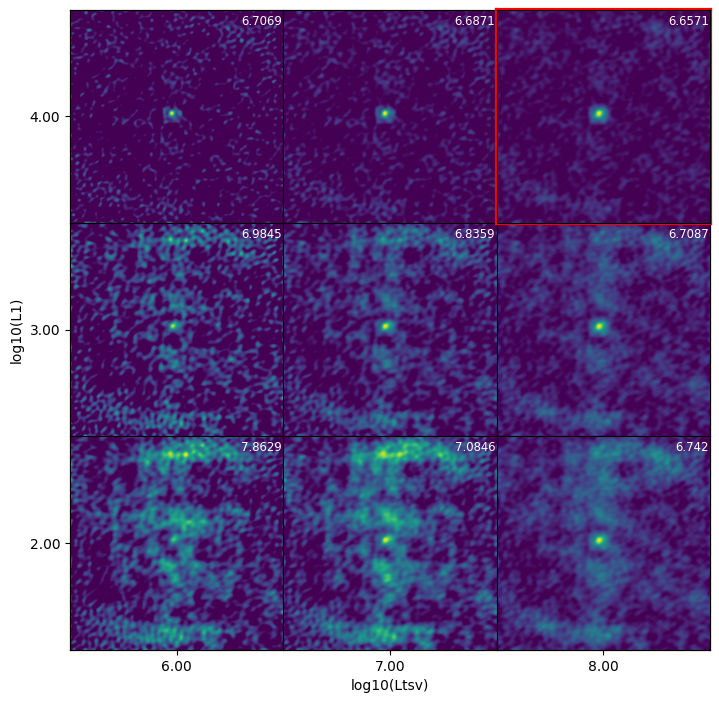

16min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e2, 1e3, 1e4]
Ltsv_list = [1e6, 1e7, 1e8]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cv', imagepolicy='full',
                       summarize=True, figfile='cvresult.png',
                       datafile='cvresult.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False)

## Accelerating cross-validation with Bayesian optimization

The `crossvalidation` method has an option to choose optimizer. Default optimizer is `'classical'` which evaluates each pair of `L1` and `Ltsv` in order to find the most reliable combination. In general, `'classical'` optimizer takes time because all combinations of given sets of `L1` and `Ltsv` must be evaluated. This makes practically difficult to seach wide range of `L1` and `Ltsv`. To address this issue, we've introduced another optimizer, `'bayesian'`. The `'bayesian'` optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12x12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the `'classical'` optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        1e+09
  L1 cost         61.895
lambda_tsv:       100
  TSV cost        0.0015169
total cost        6.1946e+10

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 61945909079.22061, c = 50000000000.00000
    3 cost = 54758622.12959

Cleaning fftw plan.

 computation time: 0.12363
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0952e+08
lambda_l1:        1e+09
  L1 cost         0
lambda_tsv:       100
  TSV cost        0
total cost        5.4759e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6765e+07
lambd

    3 cost = 41019783.65486

Cleaning fftw plan.

 computation time: 0.13316
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.204e+07
lambda_l1:        1e+10
  L1 cost         0
lambda_tsv:       1e+09
  TSV cost        0
total cost        4.102e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        10000
  L1 cost         61.895
lambda_tsv:       1e+08
  TSV cost        0.0015169
total cost        5.1965e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 51965396.81432, c = 50000000000.00000
   11 cost = 51961558.52727, c = 19277164471.47657
   21 cost = 51944134.51252, c = 7432181401.20717
   31 cost = 51891646.59677, c = 2865427665

  331 cost = 38639125.25745, c = 2152838215.67122
  341 cost = 38639124.48519, c = 2152838215.67122
  351 cost = 38639124.20862, c = 2368122037.23835
  361 cost = 38639124.03911, c = 2152838215.67122
  371 cost = 38639123.96530, c = 2152838215.67122
  381 cost = 38639123.70053, c = 1957125650.61020
  391 cost = 38639123.43714, c = 2152838215.67122
  401 cost = 38639123.35093, c = 2368122037.23835
  411 cost = 38639123.26207, c = 2368122037.23835
  421 cost = 38639123.22064, c = 2152838215.67122
  431 cost = 38639123.16073, c = 2152838215.67122
  441 cost = 38639123.11578, c = 2152838215.67122
  451 cost = 38639123.06000, c = 2152838215.67122
  461 cost = 38639122.98370, c = 2368122037.23835
  471 cost = 38639122.96711, c = 2368122037.23835
  481 cost = 38639122.94248, c = 2152838215.67122
  491 cost = 38639122.92702, c = 2152838215.67122
  501 cost = 38639122.90754, c = 2152838215.67122
  511 cost = 38639122.88679, c = 2152838215.67122
  521 cost = 38639122.87413, c = 2368122037.23835


  821 cost = 38558601.76422, c = 2152838215.67122
  831 cost = 38558601.76411, c = 2368122037.23835
  841 cost = 38558601.76399, c = 1336743153.20689
  851 cost = 38558601.76388, c = 1779205136.91837
  861 cost = 38558601.76383, c = 1779205136.91837
  871 cost = 38558601.76379, c = 2152838215.67122
  881 cost = 38558601.76377, c = 2152838215.67122
  891 cost = 38558601.76372, c = 2152838215.67122
  901 cost = 38558601.76363, c = 1957125650.61020
  911 cost = 38558601.76356, c = 2152838215.67122
  921 cost = 38558601.76353, c = 1779205136.91837
  931 cost = 38558601.76348, c = 2152838215.67122
  941 cost = 38558601.76345, c = 2152838215.67122
  951 cost = 38558601.76343, c = 1617459215.38033
  961 cost = 38558601.76342, c = 1336743153.20689
  971 cost = 38558601.76340, c = 1779205136.91837
  981 cost = 38558601.76337, c = 2152838215.67122
  991 cost = 38558601.76336, c = 1957125650.61020
 1000 cost = 38558601.76334

Cleaning fftw plan.

 computation time: 18.258
compute Fourier Transfor

  161 cost = 38633179.92013, c = 2152838215.67122
  171 cost = 38633139.17666, c = 1957125650.61020
  181 cost = 38633115.86267, c = 1957125650.61020
  191 cost = 38633105.03406, c = 1957125650.61020
  201 cost = 38633091.50052, c = 2152838215.67122
  211 cost = 38633068.62221, c = 2152838215.67122
  221 cost = 38633063.73081, c = 1336743153.20689
  231 cost = 38633060.15125, c = 2152838215.67122
  241 cost = 38633057.89306, c = 1957125650.61020
  251 cost = 38633051.89312, c = 2152838215.67122
  261 cost = 38633050.46010, c = 1215221048.36990
  271 cost = 38633048.90153, c = 1957125650.61020
  281 cost = 38633047.16832, c = 2152838215.67122
  291 cost = 38633046.42476, c = 1470417468.52757
  301 cost = 38633044.83746, c = 2152838215.67122
  311 cost = 38633044.29214, c = 2152838215.67122
  321 cost = 38633043.99448, c = 1779205136.91837
  331 cost = 38633043.53298, c = 1957125650.61020
  341 cost = 38633043.28555, c = 1957125650.61020
  351 cost = 38633042.99914, c = 1957125650.61020


  671 cost = 51328668.37635, c = 425927563.97503
  681 cost = 51328637.26140, c = 468520320.37253
  691 cost = 51328608.83218, c = 623600546.41584
  701 cost = 51328582.62194, c = 685960601.05743
  711 cost = 51328558.30827, c = 685960601.05743
  721 cost = 51328534.14982, c = 623600546.41584
  731 cost = 51328511.19959, c = 623600546.41584
  741 cost = 51328490.28986, c = 623600546.41584
  751 cost = 51328469.72097, c = 566909587.65077
  761 cost = 51328450.59865, c = 566909587.65077
  771 cost = 51328431.74731, c = 623600546.41584
  781 cost = 51328414.32579, c = 566909587.65077
  791 cost = 51328397.98382, c = 685960601.05743
  801 cost = 51328381.88323, c = 623600546.41584
  811 cost = 51328366.88538, c = 515372352.40979
  821 cost = 51328353.06778, c = 685960601.05743
  831 cost = 51328339.57671, c = 515372352.40979
  841 cost = 51328326.65795, c = 623600546.41584
  851 cost = 51328315.50142, c = 566909587.65077
  861 cost = 51328304.82829, c = 566909587.65077
  871 cost = 5132829

   11 cost = 38827232.42457, c = 19277164471.47657
   21 cost = 38709185.59909, c = 7432181401.20717
   31 cost = 38596577.91210, c = 2865427665.05840
   41 cost = 38456041.07899, c = 1104746407.60900
   51 cost = 38351308.34162, c = 1957125650.61020
   61 cost = 38304289.69718, c = 1779205136.91837
   71 cost = 38284582.19160, c = 1617459215.38033
   81 cost = 38274295.63013, c = 1470417468.52757
   91 cost = 38267894.70529, c = 1336743153.20689
  101 cost = 38263339.58026, c = 1104746407.60900
  111 cost = 38259798.80908, c = 1104746407.60900
  121 cost = 38257085.57746, c = 1004314916.00818
  131 cost = 38254933.91172, c = 1004314916.00818
  141 cost = 38253150.29945, c = 1004314916.00818
  151 cost = 38251664.30913, c = 1004314916.00818
  161 cost = 38250386.34241, c = 830012327.27949
  171 cost = 38249284.68436, c = 830012327.27949
  181 cost = 38248310.99456, c = 830012327.27949
  191 cost = 38247468.62754, c = 754556661.16317
  201 cost = 38246750.33625, c = 754556661.16317
  21

  521 cost = 38503324.28944, c = 468520320.37253
  531 cost = 38503283.54486, c = 387206876.34094
  541 cost = 38503244.03321, c = 468520320.37253
  551 cost = 38503207.54455, c = 515372352.40979
  561 cost = 38503174.20818, c = 468520320.37253
  571 cost = 38503144.63712, c = 425927563.97503
  581 cost = 38503117.17072, c = 425927563.97503
  591 cost = 38503090.53789, c = 468520320.37253
  601 cost = 38503065.04443, c = 387206876.34094
  611 cost = 38503041.41107, c = 468520320.37253
  621 cost = 38503018.92825, c = 425927563.97503
  631 cost = 38502998.10315, c = 425927563.97503
  641 cost = 38502977.24064, c = 425927563.97503
  651 cost = 38502957.11052, c = 468520320.37253
  661 cost = 38502937.98440, c = 468520320.37253
  671 cost = 38502919.38233, c = 425927563.97503
  681 cost = 38502901.68059, c = 425927563.97503
  691 cost = 38502885.05080, c = 320005682.92639
  701 cost = 38502870.03528, c = 425927563.97503
  711 cost = 38502854.97527, c = 468520320.37253
  721 cost = 3850284

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6166e+07
lambda_l1:        10000
  L1 cost         23.095
lambda_tsv:       10
  TSV cost        1.616
total cost        3.8314e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        100
  L1 cost         61.895
lambda_tsv:       1e+10
  TSV cost        0.0015169
total cost        6.637e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 66370283.45658, c = 50000000000.00000
   11 cost = 55027607.50881, c = 107179440500.00009
   21 cost = 53711326.98358, c = 107179440500.00009
   31 cost = 53220540.04452, c = 107179440500.00009
   41 cost = 53003300.88164, c = 107179440500.00009
   51 cost = 52904160.94732, c = 107179440500.00009
   61 cost = 528513

  311 cost = 39485165.72370, c = 117897384550.00011
  321 cost = 39481867.46919, c = 117897384550.00011
  331 cost = 39478714.08551, c = 107179440500.00009
  341 cost = 39475686.69436, c = 97435855000.00008
  351 cost = 39472786.96242, c = 107179440500.00009
  361 cost = 39470030.28991, c = 97435855000.00008
  371 cost = 39467442.38217, c = 117897384550.00011
  381 cost = 39465028.50180, c = 107179440500.00009
  391 cost = 39462774.03160, c = 107179440500.00009
  401 cost = 39460667.65287, c = 117897384550.00011
  411 cost = 39458706.87488, c = 107179440500.00009
  421 cost = 39456897.03155, c = 117897384550.00011
  431 cost = 39455237.41940, c = 117897384550.00011
  441 cost = 39453721.45951, c = 107179440500.00009
  451 cost = 39452353.55109, c = 107179440500.00009
  461 cost = 39451146.35030, c = 107179440500.00009
  471 cost = 39450115.22395, c = 97435855000.00008
  481 cost = 39449318.06023, c = 107179440500.00009
  491 cost = 39448801.00675, c = 107179440500.00009
  501 cost = 39

  761 cost = 39382138.20404, c = 88578050000.00006
  771 cost = 39382135.88476, c = 107179440500.00009
  781 cost = 39382132.60807, c = 80525500000.00005
  791 cost = 39382129.70382, c = 66550000000.00002
  801 cost = 39382127.36547, c = 117897384550.00011
  811 cost = 39382117.83102, c = 107179440500.00009
  821 cost = 39382110.70605, c = 97435855000.00008
  831 cost = 39382105.63784, c = 107179440500.00009
  841 cost = 39382103.38359, c = 97435855000.00008
  851 cost = 39382096.95703, c = 107179440500.00009
  861 cost = 39382093.64379, c = 88578050000.00006
  871 cost = 39382084.40879, c = 117897384550.00011
  881 cost = 39382071.06184, c = 107179440500.00009
  891 cost = 39382048.18074, c = 107179440500.00009
  901 cost = 39382016.87250, c = 107179440500.00009
  911 cost = 39381984.66997, c = 117897384550.00011
  921 cost = 39381961.23067, c = 107179440500.00009
  931 cost = 39381954.20609, c = 97435855000.00008
  941 cost = 39381952.69959, c = 88578050000.00006
  951 cost = 3938195

   41 cost = 39887452.95244, c = 107179440500.00009
   51 cost = 39785279.41349, c = 107179440500.00009
   61 cost = 39733371.34135, c = 97435855000.00008
   71 cost = 39697261.04764, c = 107179440500.00009
   81 cost = 39664873.80579, c = 97435855000.00008
   91 cost = 39636744.16511, c = 107179440500.00009
  101 cost = 39614657.34576, c = 107179440500.00009
  111 cost = 39597020.34518, c = 117897384550.00011
  121 cost = 39582020.73757, c = 107179440500.00009
  131 cost = 39569335.02943, c = 97435855000.00008
  141 cost = 39559260.25372, c = 117897384550.00011
  151 cost = 39551489.35067, c = 107179440500.00009
  161 cost = 39545247.80238, c = 107179440500.00009
  171 cost = 39539915.34335, c = 107179440500.00009
  181 cost = 39535265.12342, c = 97435855000.00008
  191 cost = 39531047.27242, c = 107179440500.00009
  201 cost = 39526911.41462, c = 107179440500.00009
  211 cost = 39522663.19249, c = 107179440500.00009
  221 cost = 39518342.20430, c = 107179440500.00009
  231 cost = 395

   11 cost = 41367825.07969, c = 19277164471.47657
   13 cost = 41257316.35022

Cleaning fftw plan.

 computation time: 0.22088
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.2515e+07
lambda_l1:        1e+07
  L1 cost         0
lambda_tsv:       10
  TSV cost        0
total cost        4.1257e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6732e+07
lambda_l1:        1e+07
  L1 cost         61.895
lambda_tsv:       10
  TSV cost        0.0015169
total cost        6.5731e+08

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1372e-05

    1 cost = 657313345.10165, c = 50000000000.00000
   11 cost = 41130770.74134, c = 19277164471.47657
   13 cost = 41019783.65486

Cleaning fftw pl

  441 cost = 51330641.52703, c = 685960601.05743
  451 cost = 51330553.21480, c = 830012327.27949
  461 cost = 51330468.46291, c = 754556661.16317
  471 cost = 51330392.02817, c = 685960601.05743
  481 cost = 51330323.79087, c = 830012327.27949
  491 cost = 51330258.98247, c = 623600546.41584
  501 cost = 51330199.39938, c = 830012327.27949
  511 cost = 51330145.13444, c = 685960601.05743
  521 cost = 51330093.99485, c = 754556661.16317
  531 cost = 51330047.61590, c = 685960601.05743
  541 cost = 51330002.58297, c = 754556661.16317
  551 cost = 51329960.40670, c = 685960601.05743
  561 cost = 51329920.91226, c = 515372352.40979
  571 cost = 51329885.41454, c = 685960601.05743
  581 cost = 51329852.13835, c = 515372352.40979
  591 cost = 51329820.51313, c = 754556661.16317
  601 cost = 51329789.67204, c = 685960601.05743
  611 cost = 51329761.19552, c = 754556661.16317
  621 cost = 51329734.77900, c = 566909587.65077
  631 cost = 51329711.04910, c = 623600546.41584
  641 cost = 5132968

  951 cost = 38333812.73380, c = 352006251.21903
  961 cost = 38333812.60762, c = 264467506.55074
  971 cost = 38333812.50283, c = 352006251.21903
  981 cost = 38333812.24997, c = 352006251.21903
  991 cost = 38333812.10742, c = 352006251.21903
 1000 cost = 38333811.99065

Cleaning fftw plan.

 computation time: 24.085
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6217e+07
lambda_l1:        10000
  L1 cost         22.43
lambda_tsv:       1000
  TSV cost        1.1766
total cost        3.8334e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6575e+07
lambda_l1:        10000
  L1 cost         61.895
lambda_tsv:       1000
  TSV cost        0.0015169
total cost        3.8907e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA usi

  291 cost = 38506338.79361, c = 623600546.41584
  301 cost = 38506114.20841, c = 623600546.41584
  311 cost = 38505915.98669, c = 623600546.41584
  321 cost = 38505733.50172, c = 623600546.41584
  331 cost = 38505568.04515, c = 515372352.40979
  341 cost = 38505421.84897, c = 515372352.40979
  351 cost = 38505286.99382, c = 468520320.37253
  361 cost = 38505164.18368, c = 468520320.37253
  371 cost = 38505051.82427, c = 566909587.65077
  381 cost = 38504948.05070, c = 468520320.37253
  391 cost = 38504853.37373, c = 515372352.40979
  401 cost = 38504768.91974, c = 425927563.97503
  411 cost = 38504690.41697, c = 468520320.37253
  421 cost = 38504619.31025, c = 425927563.97503
  431 cost = 38504554.65169, c = 515372352.40979
  441 cost = 38504492.46446, c = 515372352.40979
  451 cost = 38504437.76518, c = 515372352.40979
  461 cost = 38504388.63395, c = 425927563.97503
  471 cost = 38504343.44690, c = 425927563.97503
  481 cost = 38504302.00260, c = 468520320.37253
  491 cost = 3850426

  811 cost = 38315135.66133, c = 468520320.37253
  821 cost = 38315134.38021, c = 290914257.20581
  831 cost = 38315133.31679, c = 425927563.97503
  841 cost = 38315132.33434, c = 352006251.21903
  851 cost = 38315131.60631, c = 320005682.92639
  861 cost = 38315130.60933, c = 352006251.21903
  871 cost = 38315130.12486, c = 352006251.21903
  881 cost = 38315129.81326, c = 290914257.20581
  891 cost = 38315129.45099, c = 290914257.20581
  901 cost = 38315129.00096, c = 387206876.34094
  911 cost = 38315128.56993, c = 290914257.20581
  921 cost = 38315128.26101, c = 290914257.20581
  931 cost = 38315128.09416, c = 425927563.97503
  941 cost = 38315127.96676, c = 320005682.92639
  951 cost = 38315127.67392, c = 320005682.92639
  961 cost = 38315127.41413, c = 320005682.92639
  971 cost = 38315127.19393, c = 320005682.92639
  981 cost = 38315126.97137, c = 264467506.55074
  991 cost = 38315126.86517, c = 240425005.95522
 1000 cost = 38315126.71442

Cleaning fftw plan.

 computation time: 

  131 cost = 37956830.78703, c = 2604934240.96218
  141 cost = 37949988.00391, c = 2368122037.23835
  151 cost = 37943674.25311, c = 2368122037.23835
  161 cost = 37937844.64460, c = 2368122037.23835
  171 cost = 37932425.73032, c = 2368122037.23835
  181 cost = 37927406.61188, c = 2368122037.23835
  191 cost = 37922734.53988, c = 2368122037.23835
  201 cost = 37918379.91587, c = 2604934240.96218
  211 cost = 37914319.38376, c = 2368122037.23835
  221 cost = 37910508.82458, c = 2604934240.96218
  231 cost = 37906922.29469, c = 2604934240.96218
  241 cost = 37903535.64567, c = 2152838215.67122
  251 cost = 37900323.26452, c = 2604934240.96218
  261 cost = 37897286.70256, c = 2865427665.05840
  271 cost = 37894412.02165, c = 2152838215.67122
  281 cost = 37891685.46694, c = 2152838215.67122
  291 cost = 37889094.22847, c = 2368122037.23835
  301 cost = 37886617.69441, c = 2865427665.05840
  311 cost = 37884249.08728, c = 2865427665.05840
  321 cost = 37881975.16442, c = 2604934240.96218


  611 cost = 37740799.06325, c = 1957125650.61020
  621 cost = 37740052.14042, c = 2368122037.23835
  631 cost = 37739328.41308, c = 2152838215.67122
  641 cost = 37738617.34102, c = 2604934240.96218
  651 cost = 37737926.51984, c = 2152838215.67122
  661 cost = 37737255.52154, c = 2604934240.96218
  671 cost = 37736601.71130, c = 2368122037.23835
  681 cost = 37735964.30420, c = 1957125650.61020
  691 cost = 37735337.68919, c = 2152838215.67122
  701 cost = 37734729.76696, c = 2368122037.23835
  711 cost = 37734135.50839, c = 2368122037.23835
  721 cost = 37733557.19039, c = 2865427665.05840
  731 cost = 37732992.87133, c = 2604934240.96218
  741 cost = 37732442.51833, c = 2152838215.67122
  751 cost = 37731904.30997, c = 1957125650.61020
  761 cost = 37731377.20165, c = 1957125650.61020
  771 cost = 37730862.08912, c = 2152838215.67122
  781 cost = 37730361.18280, c = 2604934240.96218
  791 cost = 37729871.79885, c = 2368122037.23835
  801 cost = 37729391.25734, c = 2152838215.67122


Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1372e-05

    1 cost = 38366820.80739, c = 50000000000.00000
   11 cost = 38288296.70888, c = 19277164471.47657
   21 cost = 38182378.95844, c = 7432181401.20717
   31 cost = 38111505.66106, c = 2865427665.05840
   41 cost = 38054357.55151, c = 2368122037.23835
   51 cost = 38020826.15147, c = 2604934240.96218
   61 cost = 37997833.83575, c = 2368122037.23835
   71 cost = 37980017.53165, c = 2152838215.67122
   81 cost = 37965407.28504, c = 2368122037.23835
   91 cost = 37953047.44195, c = 2368122037.23835
  101 cost = 37942348.36698, c = 2368122037.23835
  111 cost = 37932889.58588, c = 2152838215.67122
  121 cost = 37924349.90371, c = 2368122037.23835
  131 cost = 37916626.28475, c = 2368122037.23835
  141 cost = 37909600.49583, c = 2368122037.23835
  151 cost = 37903144.80964, c = 2368122037.23835
  161 cost = 37897248.75210, c = 2152838215.67122
  171 cost = 37891830.79205, c 

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.6732e+07
lambda_l1:        1e+10
  L1 cost         61.895
lambda_tsv:       1
  TSV cost        0.0015169
total cost        6.1899e+11

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1372e-05

    1 cost = 618985509429.60754, c = 50000000000.00000
    3 cost = 41019783.65486

Cleaning fftw plan.

 computation time: 0.1466
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 8.204e+07
lambda_l1:        1e+10
  L1 cost         0
lambda_tsv:       1
  TSV cost        0
total cost        4.102e+07

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1: 

  191 cost = 39569138.75770, c = 107179440500.00009
  201 cost = 39563778.20868, c = 107179440500.00009
  211 cost = 39558343.08500, c = 117897384550.00011
  221 cost = 39552787.18940, c = 117897384550.00011
  231 cost = 39547194.97970, c = 107179440500.00009
  241 cost = 39541579.53678, c = 107179440500.00009
  251 cost = 39535931.77583, c = 107179440500.00009
  261 cost = 39530289.94665, c = 117897384550.00011
  271 cost = 39524741.62928, c = 97435855000.00008
  281 cost = 39519346.87096, c = 107179440500.00009
  291 cost = 39514139.93970, c = 97435855000.00008
  301 cost = 39509145.20200, c = 107179440500.00009
  311 cost = 39504380.37327, c = 117897384550.00011
  321 cost = 39499833.51718, c = 117897384550.00011
  331 cost = 39495478.55482, c = 107179440500.00009
  341 cost = 39491310.80066, c = 97435855000.00008
  351 cost = 39487352.93325, c = 107179440500.00009
  361 cost = 39483625.96220, c = 107179440500.00009
  371 cost = 39480133.00000, c = 107179440500.00009
  381 cost = 39

  631 cost = 39397893.23828, c = 73205000000.00003
  641 cost = 39397871.85598, c = 117897384550.00011
  651 cost = 39397853.93642, c = 117897384550.00011
  661 cost = 39397841.26888, c = 117897384550.00011
  671 cost = 39397828.89300, c = 97435855000.00008
  681 cost = 39397815.98461, c = 80525500000.00005
  691 cost = 39397801.45454, c = 80525500000.00005
  701 cost = 39397781.53933, c = 107179440500.00009
  711 cost = 39397765.10027, c = 107179440500.00009
  721 cost = 39397742.00482, c = 107179440500.00009
  731 cost = 39397715.62112, c = 107179440500.00009
  741 cost = 39397684.18654, c = 107179440500.00009
  751 cost = 39397642.45984, c = 117897384550.00011
  761 cost = 39397589.46905, c = 107179440500.00009
  771 cost = 39397532.82508, c = 117897384550.00011
  781 cost = 39397482.99721, c = 107179440500.00009
  791 cost = 39397445.60529, c = 117897384550.00011
  801 cost = 39397424.86297, c = 117897384550.00011
  811 cost = 39397418.20898, c = 97435855000.00008
  821 cost = 3939

   11 cost = 42080002.54826, c = 107179440500.00009
   21 cost = 40690887.64266, c = 107179440500.00009
   31 cost = 40170397.84187, c = 107179440500.00009
   41 cost = 39941816.01678, c = 107179440500.00009
   51 cost = 39838836.71370, c = 117897384550.00011
   61 cost = 39786129.94384, c = 97435855000.00008
   71 cost = 39749066.47309, c = 107179440500.00009
   81 cost = 39715607.39180, c = 107179440500.00009
   91 cost = 39686406.53615, c = 107179440500.00009
  101 cost = 39663174.83058, c = 107179440500.00009
  111 cost = 39644341.18958, c = 107179440500.00009
  121 cost = 39628075.74127, c = 107179440500.00009
  131 cost = 39614083.06000, c = 117897384550.00011
  141 cost = 39602672.49740, c = 107179440500.00009
  151 cost = 39593534.51971, c = 107179440500.00009
  161 cost = 39585896.98298, c = 107179440500.00009
  171 cost = 39579146.82324, c = 107179440500.00009
  181 cost = 39573050.72871, c = 107179440500.00009
  191 cost = 39567339.78100, c = 107179440500.00009
  201 cost = 

  441 cost = 53182932.75867, c = 117897384550.00011
  451 cost = 53182926.16133, c = 107179440500.00009
  461 cost = 53182919.57160, c = 107179440500.00009
  471 cost = 53182913.29288, c = 107179440500.00009
  481 cost = 53182910.72613, c = 107179440500.00009
  491 cost = 53182906.20927, c = 107179440500.00009
  501 cost = 53182900.62773, c = 97435855000.00008
  511 cost = 53182898.48258, c = 117897384550.00011
  521 cost = 53182896.40417, c = 107179440500.00009
  531 cost = 53182892.21356, c = 117897384550.00011
  541 cost = 53182887.67449, c = 107179440500.00009
  551 cost = 53182886.49384, c = 66550000000.00002
  561 cost = 53182885.93212, c = 117897384550.00011
  571 cost = 53182885.10834, c = 107179440500.00009
  581 cost = 53182883.95435, c = 117897384550.00011
  591 cost = 53182881.84421, c = 107179440500.00009
  601 cost = 53182881.29296, c = 88578050000.00006
  611 cost = 53182880.72148, c = 60500000000.00002
  621 cost = 53182880.08295, c = 66550000000.00002
  631 cost = 5318

  871 cost = 40004226.90317, c = 107179440500.00009
  881 cost = 40004226.85578, c = 97435855000.00008
  891 cost = 40004226.81482, c = 88578050000.00006
  901 cost = 40004226.76473, c = 107179440500.00009
  911 cost = 40004226.73264, c = 117897384550.00011
  921 cost = 40004226.66777, c = 117897384550.00011
  931 cost = 40004226.59887, c = 117897384550.00011
  941 cost = 40004226.56274, c = 117897384550.00011
  951 cost = 40004226.52890, c = 107179440500.00009
  961 cost = 40004226.50820, c = 97435855000.00008
  971 cost = 40004226.46677, c = 107179440500.00009
  981 cost = 40004226.43429, c = 107179440500.00009
  991 cost = 40004226.40410, c = 107179440500.00009
 1000 cost = 40004226.38872

Cleaning fftw plan.

 computation time: 23.919
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.889e+07
lambda_l1:        1e+05
  L1 cost         2.8836
lambda_tsv:       1e+10
  TSV cost        2.7105e-05
total cost  

  141 cost = 40218606.68339, c = 117897384550.00011
  151 cost = 40214069.73252, c = 107179440500.00009
  161 cost = 40207197.61051, c = 117897384550.00011
  171 cost = 40205983.35605, c = 88578050000.00006
  181 cost = 40204436.15082, c = 107179440500.00009
  191 cost = 40203213.04693, c = 107179440500.00009
  201 cost = 40202859.45305, c = 117897384550.00011
  211 cost = 40202102.84463, c = 97435855000.00008
  221 cost = 40200947.20241, c = 107179440500.00009
  231 cost = 40200447.83491, c = 107179440500.00009
  241 cost = 40200276.65202, c = 97435855000.00008
  251 cost = 40200245.38816, c = 107179440500.00009
  261 cost = 40200119.28230, c = 97435855000.00008
  271 cost = 40199813.40562, c = 107179440500.00009
  281 cost = 40199538.44482, c = 117897384550.00011
  291 cost = 40199444.92249, c = 117897384550.00011
  301 cost = 40199417.75541, c = 88578050000.00006
  311 cost = 40199376.29645, c = 97435855000.00008
  321 cost = 40199321.85479, c = 107179440500.00009
  331 cost = 40199

  571 cost = 39982496.22599, c = 97435855000.00008
  581 cost = 39982494.63712, c = 107179440500.00009
  591 cost = 39982493.71554, c = 107179440500.00009
  601 cost = 39982493.33023, c = 80525500000.00005
  611 cost = 39982492.94558, c = 129687123005.00012
  621 cost = 39982492.22891, c = 107179440500.00009
  631 cost = 39982491.03578, c = 117897384550.00011
  641 cost = 39982489.67616, c = 107179440500.00009
  651 cost = 39982489.38331, c = 97435855000.00008
  661 cost = 39982489.21538, c = 73205000000.00003
  671 cost = 39982488.94787, c = 80525500000.00005
  681 cost = 39982488.60353, c = 107179440500.00009
  691 cost = 39982488.18393, c = 117897384550.00011
  701 cost = 39982488.02582, c = 88578050000.00006
  711 cost = 39982487.86109, c = 107179440500.00009
  721 cost = 39982487.71495, c = 80525500000.00005
  731 cost = 39982487.55909, c = 73205000000.00003
  741 cost = 39982487.24150, c = 117897384550.00011
  751 cost = 39982486.93518, c = 117897384550.00011
  761 cost = 3998248


  wieghted chi-sq 7.6765e+07
lambda_l1:        0.1
  L1 cost         61.895
lambda_tsv:       1e+10
  TSV cost        0.0015169
total cost        5.3552e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1323e-05

    1 cost = 53551660.29119, c = 50000000000.00000
   11 cost = 42028302.21037, c = 107179440500.00009
   21 cost = 40639680.66834, c = 107179440500.00009
   31 cost = 40120307.57726, c = 107179440500.00009
   41 cost = 39893222.61890, c = 107179440500.00009
   51 cost = 39789754.13946, c = 117897384550.00011
   61 cost = 39736092.91277, c = 97435855000.00008
   71 cost = 39698359.79666, c = 117897384550.00011
   81 cost = 39664785.94168, c = 107179440500.00009
   91 cost = 39635766.26265, c = 107179440500.00009
  101 cost = 39612945.88467, c = 117897384550.00011
  111 cost = 39594675.75781, c = 97435855000.00008
  121 cost = 39

  361 cost = 39400421.97688, c = 97435855000.00008
  371 cost = 39397982.04223, c = 107179440500.00009
  381 cost = 39395683.69786, c = 107179440500.00009
  391 cost = 39393515.21537, c = 107179440500.00009
  401 cost = 39391478.40764, c = 107179440500.00009
  411 cost = 39389579.39596, c = 107179440500.00009
  421 cost = 39387817.95931, c = 117897384550.00011
  431 cost = 39386191.76721, c = 107179440500.00009
  441 cost = 39384727.17997, c = 107179440500.00009
  451 cost = 39383425.18527, c = 117897384550.00011
  461 cost = 39382286.41966, c = 107179440500.00009
  471 cost = 39381355.07557, c = 107179440500.00009
  481 cost = 39380698.37892, c = 107179440500.00009
  491 cost = 39380390.71332, c = 107179440500.00009
  501 cost = 39380352.11344, c = 73205000000.00003
  511 cost = 39380344.74582, c = 66550000000.00002
  521 cost = 39380338.79485, c = 60500000000.00002
  531 cost = 39380337.38573, c = 66550000000.00002
  541 cost = 39380335.81766, c = 88578050000.00006
  551 cost = 39380

  811 cost = 39636044.45732, c = 88578050000.00006
  821 cost = 39636042.18244, c = 117897384550.00011
  831 cost = 39636039.47043, c = 129687123005.00012
  841 cost = 39636037.51028, c = 97435855000.00008
  851 cost = 39636034.80869, c = 80525500000.00005
  861 cost = 39636032.34448, c = 66550000000.00002
  871 cost = 39636030.39233, c = 60500000000.00002
  881 cost = 39636029.10779, c = 117897384550.00011
  891 cost = 39636028.66681, c = 80525500000.00005
  901 cost = 39636027.41968, c = 88578050000.00006
  911 cost = 39636026.05243, c = 55000000000.00001
  921 cost = 39636025.33124, c = 60500000000.00002
  931 cost = 39636024.33244, c = 73205000000.00003
  941 cost = 39636022.85026, c = 66550000000.00002
  951 cost = 39636022.12731, c = 107179440500.00009
  961 cost = 39636021.16935, c = 66550000000.00002
  971 cost = 39636019.83014, c = 66550000000.00002
  981 cost = 39636018.77671, c = 129687123005.00012
  991 cost = 39636017.30904, c = 107179440500.00009
 1000 cost = 39636015.664

   91 cost = 51055986.30022, c = 3151970431.56424
  101 cost = 51048588.90125, c = 3151970431.56424
  111 cost = 51042228.50609, c = 2865427665.05840
  121 cost = 51036734.25134, c = 2865427665.05840
  131 cost = 51031918.71689, c = 2865427665.05840
  141 cost = 51027664.64668, c = 2865427665.05840
  151 cost = 51023898.44339, c = 2865427665.05840
  161 cost = 51020546.99980, c = 2604934240.96218
  171 cost = 51017546.69366, c = 2604934240.96218
  181 cost = 51014860.91861, c = 2865427665.05840
  191 cost = 51012437.22963, c = 2604934240.96218
  201 cost = 51010238.73913, c = 2604934240.96218
  211 cost = 51008220.75719, c = 2368122037.23834
  221 cost = 51006377.43744, c = 2604934240.96218
  231 cost = 51004689.24763, c = 2604934240.96218
  241 cost = 51003145.00808, c = 2604934240.96218
  251 cost = 51001719.41843, c = 2865427665.05840
  261 cost = 51000397.93079, c = 2604934240.96218
  271 cost = 50999174.61276, c = 2604934240.96218
  281 cost = 50998037.31789, c = 2604934240.96218


  571 cost = 37996830.66020, c = 1617459215.38033
  581 cost = 37996584.48565, c = 1617459215.38033
  591 cost = 37996348.53141, c = 1336743153.20689
  601 cost = 37996119.81221, c = 1779205136.91837
  611 cost = 37995903.41792, c = 1617459215.38033
  621 cost = 37995690.62280, c = 1957125650.61020
  631 cost = 37995480.58489, c = 1779205136.91837
  641 cost = 37995274.68987, c = 1470417468.52757
  651 cost = 37995074.94583, c = 1617459215.38033
  661 cost = 37994882.78572, c = 1336743153.20689
  671 cost = 37994694.80340, c = 1470417468.52757
  681 cost = 37994512.51079, c = 1470417468.52757
  691 cost = 37994337.33833, c = 1336743153.20689
  701 cost = 37994166.45849, c = 1336743153.20689
  711 cost = 37993999.94544, c = 1617459215.38033
  721 cost = 37993839.45147, c = 1336743153.20689
  731 cost = 37993683.66804, c = 1470417468.52757
  741 cost = 37993529.28851, c = 1004314916.00818
  751 cost = 37993377.52130, c = 1215221048.36990
  761 cost = 37993225.14721, c = 1470417468.52757


compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 7.7096e+07
lambda_l1:        1000
  L1 cost         61.895
lambda_tsv:       0.1
  TSV cost        0.0015169
total cost        3.861e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1657e-05

    1 cost = 38610066.20481, c = 50000000000.00000
   11 cost = 38533509.29046, c = 19277164471.47657
   21 cost = 38428862.30246, c = 7432181401.20717
   31 cost = 38362785.65488, c = 2865427665.05840
   41 cost = 38312359.75054, c = 2368122037.23835
   51 cost = 38284489.35165, c = 2604934240.96218
   61 cost = 38266157.40532, c = 2368122037.23835
   71 cost = 38252614.63362, c = 2152838215.67122
   81 cost = 38242200.50998, c = 2368122037.23835
   91 cost = 38233819.98288, c = 2152838215.67122
  101 cost = 38226963.43140,

  391 cost = 37969210.77785, c = 1957125650.61020
  401 cost = 37968715.80488, c = 1617459215.38033
  411 cost = 37968243.63272, c = 1617459215.38033
  421 cost = 37967790.05739, c = 1779205136.91837
  431 cost = 37967353.62636, c = 1957125650.61020
  441 cost = 37966936.13680, c = 1617459215.38033
  451 cost = 37966532.53086, c = 1617459215.38033
  461 cost = 37966150.42241, c = 1617459215.38033
  471 cost = 37965785.27569, c = 1470417468.52757
  481 cost = 37965434.06257, c = 1470417468.52757
  491 cost = 37965098.88196, c = 1617459215.38033
  501 cost = 37964776.71072, c = 1617459215.38033
  511 cost = 37964465.39144, c = 1470417468.52757
  521 cost = 37964163.84498, c = 1617459215.38033
  531 cost = 37963874.55570, c = 1779205136.91837
  541 cost = 37963593.41137, c = 1617459215.38033
  551 cost = 37963317.01661, c = 1779205136.91837
  561 cost = 37963054.29715, c = 1617459215.38033
  571 cost = 37962801.80020, c = 1617459215.38033
  581 cost = 37962560.50650, c = 1617459215.38033


  871 cost = 50814752.99144, c = 3151970431.56424
  881 cost = 50814335.20490, c = 2604934240.96218
  891 cost = 50813925.60593, c = 3151970431.56424
  901 cost = 50813524.97067, c = 2865427665.05840
  911 cost = 50813130.63274, c = 3151970431.56424
  921 cost = 50812746.13686, c = 2865427665.05840
  931 cost = 50812369.67934, c = 2865427665.05840
  941 cost = 50812002.63087, c = 2865427665.05840
  951 cost = 50811642.92244, c = 2865427665.05840
  961 cost = 50811293.38586, c = 2865427665.05840
  971 cost = 50810948.94957, c = 2865427665.05840
  981 cost = 50810613.30884, c = 2604934240.96218
  991 cost = 50810285.66443, c = 2865427665.05840
 1000 cost = 50809993.71210

Cleaning fftw plan.

 computation time: 38.42
compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0162e+08
lambda_l1:        0.1
  L1 cost         304.69
lambda_tsv:       0.1
  TSV cost        1.6883
total cost        5.081e+07

compute Fourie

  191 cost = 37816927.89982, c = 2368122037.23835
  201 cost = 37812768.88946, c = 2152838215.67122
  211 cost = 37808841.79839, c = 2368122037.23835
  221 cost = 37805119.17273, c = 2368122037.23835
  231 cost = 37801585.33964, c = 2368122037.23835
  241 cost = 37798228.81092, c = 2368122037.23835
  251 cost = 37795034.37846, c = 2604934240.96218
  261 cost = 37791981.73281, c = 2368122037.23835
  271 cost = 37789066.16348, c = 2604934240.96218
  281 cost = 37786290.23453, c = 2368122037.23835
  291 cost = 37783641.61137, c = 2152838215.67122
  301 cost = 37781108.95893, c = 1957125650.61020
  311 cost = 37778690.76026, c = 2604934240.96218
  321 cost = 37776386.74272, c = 2368122037.23835
  331 cost = 37774191.40953, c = 2152838215.67122
  341 cost = 37772099.36117, c = 1957125650.61020
  351 cost = 37770090.16143, c = 2604934240.96218
  361 cost = 37768173.39486, c = 2368122037.23835
  371 cost = 37766336.33242, c = 2368122037.23835
  381 cost = 37764575.30532, c = 2152838215.67122


  671 cost = 38013482.36785, c = 2152838215.67122
  681 cost = 38012828.14191, c = 2152838215.67122
  691 cost = 38012189.69625, c = 1779205136.91837
  701 cost = 38011566.39352, c = 1957125650.61020
  711 cost = 38010960.14182, c = 2368122037.23835
  721 cost = 38010371.22677, c = 1957125650.61020
  731 cost = 38009799.53684, c = 2152838215.67122
  741 cost = 38009240.61028, c = 2368122037.23835
  751 cost = 38008691.55904, c = 2152838215.67122
  761 cost = 38008158.86189, c = 2604934240.96218
  771 cost = 38007639.75825, c = 2152838215.67122
  781 cost = 38007133.77874, c = 1957125650.61020
  791 cost = 38006638.44703, c = 2152838215.67122
  801 cost = 38006151.70331, c = 1957125650.61020
  811 cost = 38005678.23655, c = 1779205136.91837
  821 cost = 38005214.67486, c = 2152838215.67122
  831 cost = 38004766.60193, c = 2368122037.23835
  841 cost = 38004328.59528, c = 2368122037.23835
  851 cost = 38003898.46531, c = 2152838215.67122
  861 cost = 38003476.50457, c = 2368122037.23835


{'L1': 10000.0, 'Ltsv': 100000000.0}

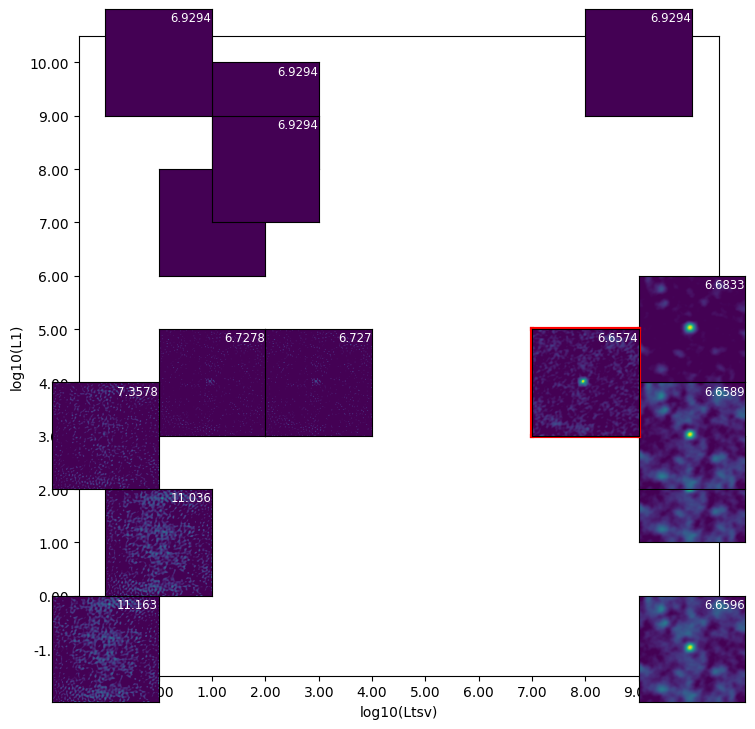

19min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv2

L1_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
Ltsv_list =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cvbayes', imagepolicy='full',
                       summarize=True, figfile='cvresult2.png',
                       datafile='cvresult2.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False,
                      optimizer='bayesian', bayesopt_maxiter=15)

## Processing using a Parameter File

Imaging and cross-validation can be processed using parameters stored in a parameter file. 
For reading the parameter file, `loadParam` is used. 
And also, the used parameters can be stored by `saveParam` in a parameter file of `*.param`. 
(The parameters in cross-validations are automatically stored, such as "`cvname.param`".) 
You manually make the parameter file and can apply that for imaging and cross-validation as well. 

For example, you can perform imaging or cross-validation using the parameter file "test.param" as follows,

```python
from priism import runner
hh=runner.Session.loadParam('test.param')
hh.run(overwrite=True)
```

or

```python
from priism import runner
hh=runner.Session.loadParam('test.param')
hh.crossValidation(overwrite=True)
```

The sample of the parameter file for the classical cross-validation is as follows,

```text
vis:            twhya_b7cont.smoothed.ms
field:          0
spw:            0
ch:             24~25
datacolumn:     data
imname:         twhya_b7cont.fits
imsize:         [256, 256]
cell:           ['0.08arcsec']
nchan:          1
start:          0
width:          2
cvname:         twhya_b7cont.cv
solver:         mfista_nufft
l1:             1000.0
ltsv:           10000000.0
maxiter:        1000
numFold:        4
imagePolicy:    full
l1List:         [100.0, 1000.0, 10000.0]
ltsvList:       [1000000.0, 10000000.0, 100000000.0]
optimizer:      classical
bayesopt_maxiter:       15
```

## Display Final Image

The created image is displayed here using the <code>matplotlib</code> modular. <br>
By default, if the final image with classical cross-validation exist, that is shown. Here, the area of 100&times;100 pixels around central region of the image is shown. 

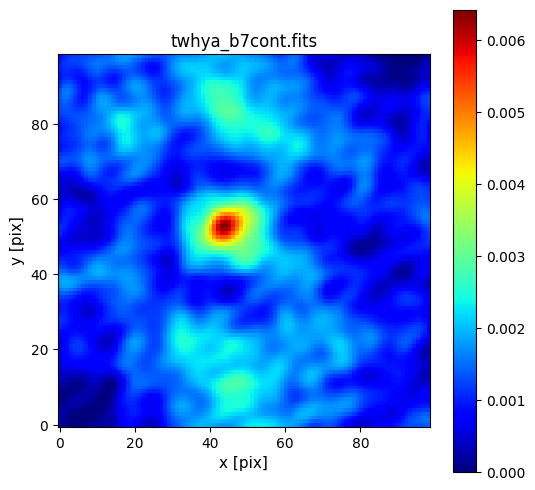

In [17]:
from astropy.io import fits
from matplotlib import pyplot as plt

imname = 'twhya_b7cont.fits'
figname = imname.replace('fits', 'png')

pixs=256; imwd=100; exwd = (pixs-imwd) // 2
_, aa=plt.subplots(1,1, figsize=(6,6))
im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.05)
plt.show()